# MOLI for Drug Response Prediction

The following code is the interpretation of the original MOLI for drug reponse prediction analysis as presented in 
[MOLI: multi-omics late integration with deep neural networks for drug response prediction][1] by Sharifi-Noghabi *et al.* (2019)
using the moli package provided in this repository and the optimized MOLI_Complete hyperparameters provided in Table S3.

[1]: https://doi.org/10.1093/bioinformatics/btz318

In [1]:
import moli
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
device = torch.device('cuda')

import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})

## Drug Response Data

The harmonized drug response data was downloaded from the [MOLI Zenodo repository Version 3][2].
Seven drug, training set, and training set combinations are used in the analysis

[2]: https://doi.org/10.5281/zenodo.4036592

In [2]:
zenodo_dir = './data/4036592'

In [3]:
study_sets = pd.DataFrame([
    ('GDSC', 'PDX', 'Cetuximab', 0.53),
    ('GDSC', 'PDX', 'Erlotinib', 0.63),
    ('GDSC', 'PDX', 'Gemcitabine', 0.64),
    ('GDSC', 'PDX', 'Paclitaxel', 0.74),
    ('GDSC', 'TCGA', 'Cisplatin', 0.66),
    ('GDSC', 'TCGA', 'Docetaxel', 0.58),
    ('GDSC', 'TCGA', 'Gemcitabine', 0.65)
], columns = ['training set', 'testing set', 'drug', 'reported auc'])
study_sets

,training set,testing set,drug,reported auc
0,GDSC,PDX,Cetuximab,0.53
1,GDSC,PDX,Erlotinib,0.63
2,GDSC,PDX,Gemcitabine,0.64
3,GDSC,PDX,Paclitaxel,0.74
4,GDSC,TCGA,Cisplatin,0.66
5,GDSC,TCGA,Docetaxel,0.58
6,GDSC,TCGA,Gemcitabine,0.65


## Optimal Hyperparameters

Set of optimal hyperparameters for each study set as described in Table S3 for MOLI Complete. These are accessible through the function `moli.utils.optimal_hyperparameters()`.

Due to the small size of test sets, the prediction of the resulting networks can vary greatly. A total of 100 replicates was performed for each of the study sets in order to observe the distribution of test AUCs.

In [4]:
%%capture output

replicates = 100
test_results = []
stdscaler = StandardScaler()

for study_set in study_sets.to_dict('records'):
    ds = moli.utils.get_dataset(study_set['drug'], study_set['training set'], study_set['testing set'], zenodo_dir)
    hp = moli.utils.optimal_hyperparameters(study_set['drug'], study_set['training set'], study_set['testing set'])
    # training set
    train_exp = stdscaler.fit_transform(ds['train']['expression'])
    train_exp = torch.FloatTensor(train_exp).to(device)
    train_mut = torch.FloatTensor(ds['train']['mutation']).to(device)
    train_cna = torch.FloatTensor(ds['train']['cna']).to(device)
    train_y = torch.FloatTensor(ds['train']['response']).to(device)
    # test set
    test_exp = stdscaler.transform(ds['test']['expression'])
    test_exp = torch.FloatTensor(test_exp).to(device)
    test_mut = torch.FloatTensor(ds['test']['mutation']).to(device)
    test_cna = torch.FloatTensor(ds['test']['cna']).to(device)
    test_y = torch.FloatTensor(ds['test']['response']).to(device)
    # Generate datasets
    train_dataset = torch.utils.data.TensorDataset(train_exp, train_mut, train_cna, train_y)
    train_dataloader = moli.utils.moli_dataloader(train_dataset, hp['batch_size'])
    test_dataset = torch.utils.data.TensorDataset(test_exp, test_mut, test_cna, test_y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=hp['batch_size'])
    for ridx in range(replicates):
        # Create network
        net = moli.nn.MoliNet(train_exp.shape[1], hp['exp_hl'], hp['exp_dr'], 
                              train_mut.shape[1], hp['mut_hl'], hp['mut_dr'],
                              train_cna.shape[1], hp['cna_hl'], hp['cna_dr'],
                              hp['cls_dr']).to(device)
        # Create optimizer
        optimizer = moli.optim.MoliAdagrad(net, hp['exp_lr'], hp['mut_lr'], hp['cna_lr'], 
                                           hp['cls_lr'], hp['cls_wd'])
        # Train network
        for ep in range(hp['epochs']):
            net.train()
            for i, (dataE, dataM, dataC, target) in enumerate(train_dataloader):
                if torch.mean(target) == 0. or torch.mean(target) == 1. or len(target)<=2:
                    continue
                emb, out = net(dataE, dataM, dataC)
                if torch.any(torch.isnan(out)).item():
                    break
                loss = moli.loss.moli_combination_loss(out, target, emb, hp['margin'], hp['gamma'])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        if torch.any(torch.isnan(out)).item():
            continue
        # Calculate test set AUC
        with torch.no_grad():
            net.eval()
            test_out = torch.tensor([], device=device)
            test_target = torch.tensor([], device=device)
            for dataE, dataM, dataC, target in test_dataloader:
                _, tout = net(dataE, dataM, dataC)
                test_out = torch.cat((test_out, tout), 0)
                test_target = torch.cat((test_target, target), 0)
            test_auc = roc_auc_score(test_target.cpu().detach().numpy(), test_out.cpu().detach().numpy())
            test_results.append({
                'drug': study_set['drug'], 'training set': study_set['training set'], 
                'testing set': study_set['testing set'], 'ridx': ridx, 'auc': test_auc
            })

test_df = pd.DataFrame(test_results)

## Results

The following is a plot of the observed test AUCs resulting from networks trained with the provided hyperparameters.
The reported AUC from the MOLI paper is displayed as a red X. For all sets except for PDX Cetuximab, the reported AUC
falls within the set of observed AUCs. If the cross validation scripts are what was used for the original calculations,
[line 136 of MOLI_Complete/Cetuximab_cvSoftTripletClassifierNetv16_Script.py](https://github.com/hosseinshn/MOLI/blob/c83d6d4c7e042ff4da7c7e3df0a7c8d030d37b8b/Cross%20validation/MOLI%20Complete/Cetuximab_cvSoftTripletClassifierNetv16_Script.py#L136) shows that mutation data was mistakenly used for the CNA validation set. This may explain
the poor performance of that model.

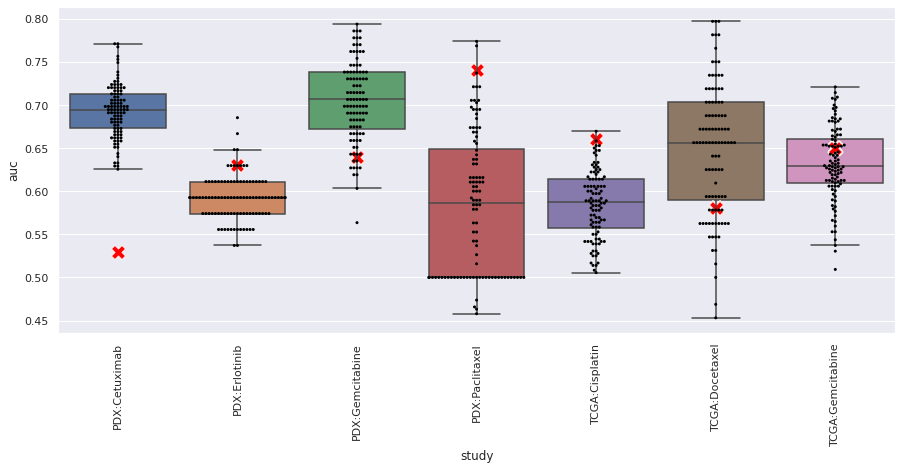

In [5]:
plot_df = test_df.merge(study_sets)
plot_df['study'] = plot_df['testing set'] + ':' + plot_df['drug']
ax = sns.boxplot(y='auc', x='study', data=plot_df, showfliers = False)
ax.tick_params(axis='x', labelrotation=90)
ax = sns.scatterplot(y='reported auc', x='study', data=plot_df, color='red', alpha=0.7, marker='X', s=200, axes=ax)
ax = sns.swarmplot(y='auc', x='study', data=plot_df, color='black', s=3, axes=ax)


In [6]:
pd.set_option('display.precision', 2)
(test_df
 .groupby(['drug','training set','testing set'])
 .agg(**{"min auc": ('auc', 'min'), 'mean auc': ('auc', 'mean'), 'median auc': ('auc', 'median'), 'max auc': ('auc', 'max')})
 .reset_index()
 .merge(study_sets)
)

,drug,training set,testing set,min auc,mean auc,median auc,max auc,reported auc
0,Cetuximab,GDSC,PDX,0.63,0.69,0.69,0.77,0.53
1,Cisplatin,GDSC,TCGA,0.51,0.58,0.59,0.67,0.66
2,Docetaxel,GDSC,TCGA,0.45,0.65,0.66,0.80,0.58
3,Erlotinib,GDSC,PDX,0.54,0.59,0.59,0.69,0.63
4,Gemcitabine,GDSC,PDX,0.56,0.70,0.71,0.79,0.64
5,Gemcitabine,GDSC,TCGA,0.51,0.63,0.63,0.72,0.65
6,Paclitaxel,GDSC,PDX,0.46,0.58,0.59,0.77,0.74
